## Useful functions

You don't need to change these functions, and you don't have to necessarilty use them to complete your assignment. 

In [12]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score

# plot one or more features (using separate plots) for a start and end date, if y is set then it shows the anomalies
#  (could be predicted or real if ground truth used)
def plot_features(df, start_day, start_year, end_day, end_year, features, y=None):
    # Filter the period
    mask = (
        (df['year'] > start_year) | 
        ((df['year'] == start_year) & (df['day_of_year'] >= start_day))
    ) & (
        (df['year'] < end_year) | 
        ((df['year'] == end_year) & (df['day_of_year'] <= end_day))
    )
    df_period = df[mask].copy()
    df_period = df_period.reset_index(drop=False)  # Keep original indices for mapping y
    df_period['date'] = pd.to_datetime(
        df_period['year'].astype(int).astype(str) + df_period['day_of_year'].astype(int).astype(str).str.zfill(3), format='%Y%j')

    if isinstance(features, str):
        features = [features]

    for feature in features:
        plt.figure(figsize=(10, 4))
        plt.plot(df_period['date'], df_period[feature], marker='o', linestyle='-')

        # If y is provided, plot anomalies
        if y is not None:
            anomaly_indices = df_period[df_period['index'].map(lambda idx: y[idx] == -1)].index
            plt.scatter(
                df_period.loc[anomaly_indices, 'date'],
                df_period.loc[anomaly_indices, feature],
                color='red', marker='x', s=100, label='Anomaly'
            )
            plt.legend()

        plt.title(f'{feature} over time')
        plt.xlabel('Date')
        plt.ylabel(feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# show a summary of the dataset, not crucial, but useful to understand the data
def print_summary(y_true):
    total = len(y_true)
    n_anomalies = (y_true == -1).sum()
    n_normals = (y_true == 1).sum()

    print("Dataset Summary:")
    print(f"Total instances:         {total}")
    print(f"Normal instances (1):    {n_normals}")
    print(f"Anomalous instances (-1): {n_anomalies}")
    print(f"Anomaly ratio:           {n_anomalies / total:.3%}")

# plot detections, useful when you already have the predictions and want to observe then on the data for each feature
def plot_detection(df, y_true, y_pred, start_day, start_year, end_day, end_year, feature):
    mask = (
        (df['year'] > start_year) | 
        ((df['year'] == start_year) & (df['day_of_year'] >= start_day))
    ) & (
        (df['year'] < end_year) | 
        ((df['year'] == end_year) & (df['day_of_year'] <= end_day))
    )
    df_period = df[mask].copy()
    idx_period = df_period.index
    df_period['date'] = pd.to_datetime(
    df_period['year'].astype(int).astype(str) + df_period['day_of_year'].astype(int).astype(str).str.zfill(3), format='%Y%j')
    y_true_period = y_true[idx_period]
    y_pred_period = y_pred[idx_period]

    correct = (y_true_period == -1) &  (y_pred_period == -1)
    missed = (y_true_period == -1) & (y_pred_period != -1)
    false_pos = (y_true_period != -1) & (y_pred_period == -1)

    plt.figure(figsize=(10, 4))
    plt.plot(df_period['date'], df_period[feature], label=feature, color='blue', linestyle='-')
    plt.scatter(df_period.loc[correct, 'date'], df_period.loc[correct, feature], 
                marker='x', color='green', label='Correct Anomaly')
    plt.scatter(df_period.loc[missed, 'date'], df_period.loc[missed, feature], 
                marker='x', color='red', label='Missed Anomaly')
    plt.scatter(df_period.loc[false_pos, 'date'], df_period.loc[false_pos, feature], 
                marker='x', color='orange', label='False Positive')

    plt.title(f'{feature} with Detected Anomalies')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# to facilitate the visualization of the results for the anomaly detection methods in part 1
def evaluate_predictions(y_true, y_pred, model_name="unnamed", header=True):
    # convert from -1 to 1 (1 for anomaly, 0 for normal) for evaluating
    y_true_binary = (y_true == -1).astype(int)
    y_pred_binary = (y_pred == -1).astype(int)

    recall = recall_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)

    correct = (y_true == -1) & (y_pred == -1)
    missed = (y_true == -1) & (y_pred != -1)
    false_positives = (y_true != -1) & (y_pred == -1)

    if header:
        print("| Model | Recall | Precision | Correct | Missed | False Positives |")
        print("|-------|--------|-----------|---------|--------|------------------|")
    
    print(f"| {model_name} | {recall:.3f} | {precision:.3f} | {correct.sum()} | {missed.sum()} | {false_positives.sum()} |")

## Example: reading and visualizing the data

In [13]:
import os
import pandas as pd

# Loading the data. y2122 contains the 'labels'
df2122 = None
y2122 = None

# Check and load if files exist
if os.path.exists("GenSyn2122.csv") and os.path.exists("GenSyn_labels2122.csv"):
    print("Loading GenSyn2122 dataset...")
    df2122 = pd.read_csv("GenSyn2122.csv")
    # -1 = anomaly, 1 = normal
    y2122 = pd.read_csv("GenSyn_labels2122.csv")['anomaly_label'].values

# Visualise part of the data...
# plot_features(df2122, 1, 2021, 100, 2021, ['temperature','energy_usage', 'season'])
display(df2122)

Loading GenSyn2122 dataset...


,year,day_of_year,season,temperature,humidity,energy_usage
0,2021,1,summer,19.708638,78.625889,11.731837
1,2021,2,summer,20.703554,78.350411,13.453957
2,2021,3,summer,21.339178,82.736788,15.393096
3,2021,4,summer,20.823304,79.921728,16.657684
4,2021,5,summer,22.277698,80.406175,16.927320
...,...,...,...,...,...,...
725,2022,361,summer,24.648768,79.422802,18.579817
726,2022,362,summer,24.362897,80.541095,19.394421
727,2022,363,summer,24.730546,85.748327,20.060006
728,2022,364,summer,26.975549,81.506959,20.840548


### Example: Using function evaluate_predictions

In [14]:
# evaluate_predictions(y_true=y2122, y_pred=the predictions of your model, model_name="name of the model", header=True):
# for example, if we use the ground truth to evaluate. You can past the result on a markdown cell to get a nice looking table
evaluate_predictions(y_true=y2122, y_pred=y2122, model_name="example", header=True)

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| example | 1.000 | 1.000 | 18 | 0 | 0 |


| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| example | 1.000 | 1.000 | 18 | 0 | 0 |

### Example: plotting anomalies using plot_detection

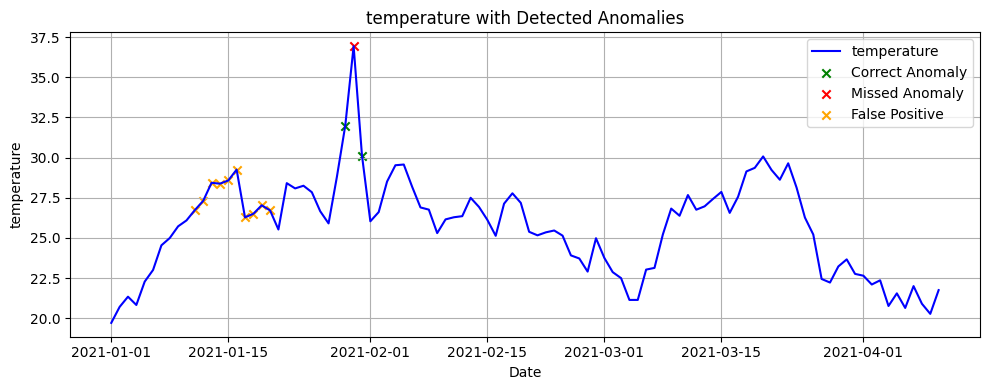

In [15]:
# generating some fake predictions for the plot
fake_preds=y2122.copy()
fake_preds[10:20] = -1
fake_preds[29] = 1
plot_detection(df=df2122, y_true=y2122, y_pred=fake_preds, start_day=1, start_year=2021, end_day=100, end_year=2021, feature="temperature")

### Example: using function plot_features

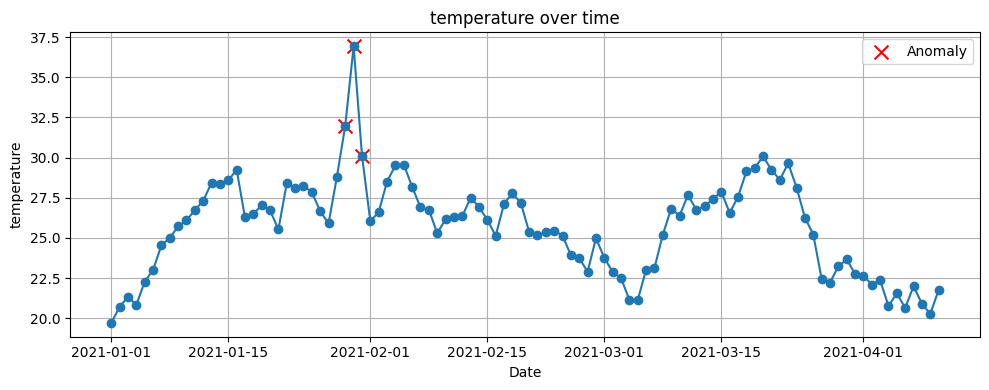

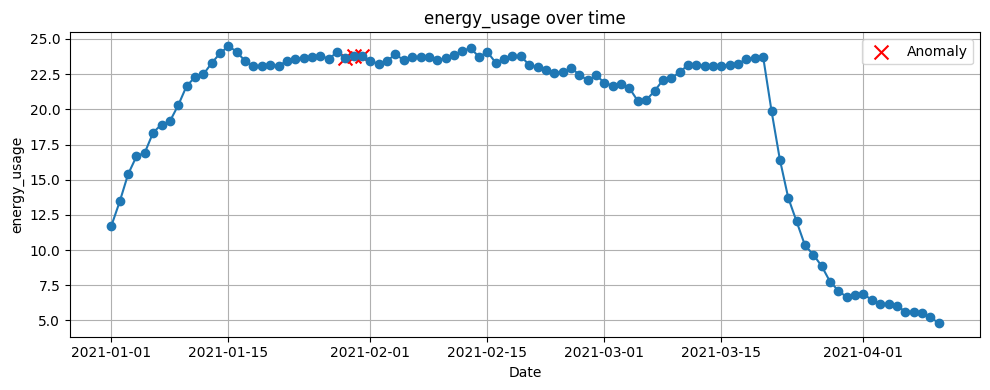

In [16]:
plot_features(df=df2122, y=y2122, start_day=1, start_year=2021, end_day=100, end_year=2021, features=["temperature", "energy_usage"])

### Statistics about the anomalies

In [11]:
print_summary(y2122)

Dataset Summary:
Total instances:         730
Normal instances (1):    712
Anomalous instances (-1): 18
Anomaly ratio:           2.466%
